In [49]:
# !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
# !pip install matplotlib
# !pip install ema-pytorch
# !pip install tqdm
# !pip install wandb
# !pip install numpy
# !pip install kaggle
# !pip install pillow
# !pip install pandas
# !pip install scikit-learn
# !pip install --upgrade ipywidgets

### LINK: https://github.com/yelboudouri/EmoNeXt/tree/master

In [50]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.hub import load_state_dict_from_url
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from torchvision.ops import StochasticDepth

In [51]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### EmoNeXt Model Defenition

In [52]:
model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_small_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth",
    "convnext_base_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth",
    "convnext_large_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth",
    "convnext_tiny_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth",
    "convnext_small_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth",
    "convnext_base_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth",
    "convnext_large_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth",
    "convnext_xlarge_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth",
}


class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class DotProductSelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(DotProductSelfAttention, self).__init__()
        self.input_dim = input_dim
        self.norm = nn.LayerNorm(input_dim)
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = self.norm(x)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        scale = 1 / math.sqrt(math.sqrt(self.input_dim))
        scores = torch.matmul(query, key.transpose(-2, -1)) * scale
        attention_weights = torch.softmax(scores, dim=-1)

        attended_values = torch.matmul(attention_weights, value)
        output = attended_values + x

        return output, attention_weights


class LayerNorm(nn.Module):
    r"""LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """

    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape,)

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(
                x, self.normalized_shape, self.weight, self.bias, self.eps
            )
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


class Block(nn.Module):
    r"""ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """

    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(
            dim, dim, kernel_size=7, padding=3, groups=dim
        )  # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(
            dim, 4 * dim
        )  # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = (
            nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)
            if layer_scale_init_value > 0
            else None
        )
        self.stochastic_depth = StochasticDepth(drop_path, "row")

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        x = input + self.stochastic_depth(x)
        return x


class EmoNeXt(nn.Module):
    def __init__(
        self,
        in_chans=3,
        num_classes=1000,
        depths=None,
        dims=None,
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
    ):
        super().__init__()

        if dims is None:
            dims = [96, 192, 384, 768]
        if depths is None:
            depths = [3, 3, 9, 3]

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 52 * 52, 32), nn.ReLU(True), nn.Linear(32, 3 * 2)
        )

        self.downsample_layers = (
            nn.ModuleList()
        )  # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first"),
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                nn.Conv2d(dims[i], dims[i + 1], kernel_size=2, stride=2),
                SELayer(dims[i + 1]),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = (
            nn.ModuleList()
        )  # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[
                    Block(
                        dim=dims[i],
                        drop_path=dp_rates[cur + j],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                    for j in range(depths[i])
                ]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)  # final norm layer
        self.attention = DotProductSelfAttention(dims[-1])
        self.head = nn.Linear(dims[-1], num_classes)

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(
            torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float)
        )

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 52 * 52)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners=True)

        return x

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(
            x.mean([-2, -1])
        )  # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x, labels=None, class_weights=None):
    # def forward(self, x, labels=None):
        x = self.stn(x)
        x = self.forward_features(x)
        _, weights = self.attention(x)
        logits = self.head(x)

        if labels is not None:
            mean_attention_weight = torch.mean(weights)
            attention_loss = torch.mean((weights - mean_attention_weight) ** 2)

            # loss = F.cross_entropy(logits, labels, label_smoothing=0.2) + attention_loss
            loss = F.cross_entropy(logits, labels, weight=class_weights, label_smoothing=0.2) + attention_loss # Using class weights
            return torch.argmax(logits, dim=1), logits, loss

        return torch.argmax(logits, dim=1), logits


def get_model(num_classes, model_size="tiny", in_22k=False):
    if model_size == "tiny":
        depths = [3, 3, 9, 3]
        dims = [96, 192, 384, 768]
        url = (
            model_urls["convnext_tiny_22k"]
            if in_22k
            else model_urls["convnext_tiny_1k"]
        )
    elif model_size == "small":
        depths = [3, 3, 27, 3]
        dims = [96, 192, 384, 768]
        url = (
            model_urls["convnext_small_22k"]
            if in_22k
            else model_urls["convnext_small_1k"]
        )
    elif model_size == "base":
        depths = [3, 3, 27, 3]
        dims = [128, 256, 512, 1024]
        url = (
            model_urls["convnext_base_22k"]
            if in_22k
            else model_urls["convnext_base_1k"]
        )
    elif model_size == "large":
        depths = [3, 3, 27, 3]
        dims = [192, 384, 768, 1536]
        url = (
            model_urls["convnext_large_22k"]
            if in_22k
            else model_urls["convnext_large_1k"]
        )
    else:
        depths = [3, 3, 27, 3]
        dims = [256, 512, 1024, 2048]
        url = model_urls["convnext_xlarge_22k"]

    default_num_classes = 1000
    if in_22k:
        default_num_classes = 21841

    net = EmoNeXt(
        depths=depths, dims=dims, num_classes=default_num_classes, drop_path_rate=0.1
    )

    state_dict = load_state_dict_from_url(url=url)
    net.load_state_dict(state_dict["model"], strict=False)
    net.head = nn.Linear(dims[-1], num_classes)

    return net

### Scheduler

In [53]:
import math
import torch
from torch.optim.lr_scheduler import LRScheduler


class CosineAnnealingWithWarmRestartsLR(LRScheduler):
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        warmup_steps: int = 128,
        cycle_steps: int = 512,
        min_lr: float = 0.0,
        max_lr: float = 1e-3,
    ):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.cycle_steps = cycle_steps
        self.min_lr = min_lr
        self.max_lr = max_lr

        self.steps_counter = 0

        super().__init__(optimizer)

    def step(self, epoch=None):
        self.steps_counter += 1

        current_cycle_steps = self.steps_counter % self.cycle_steps

        if current_cycle_steps < self.warmup_steps:
            current_lr = (
                self.min_lr
                + (self.max_lr - self.min_lr) * current_cycle_steps / self.warmup_steps
            )
        else:
            current_lr = (
                self.min_lr
                + (self.max_lr - self.min_lr)
                * (
                    1
                    + math.cos(
                        math.pi
                        * (current_cycle_steps - self.warmup_steps)
                        / (self.cycle_steps - self.warmup_steps)
                    )
                )
                / 2
            )

        for param_group in self.optimizer.param_groups:
            param_group["lr"] = current_lr

### Training Model

In [66]:
import argparse
import random
import sys
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from ema_pytorch import EMA
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import wandb

seed = 2001
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class Trainer:
    def __init__(
        self,
        model,
        training_dataloader,
        validation_dataloader,
        testing_dataloader,
        classes,
        output_dir,
        max_epochs: int = 10000,
        early_stopping_patience: int = 12,
        execution_name=None,
        lr: float = 1e-4,
        amp: bool = False,
        ema_decay: float = 0.99,
        ema_update_every: int = 16,
        gradient_accumulation_steps: int = 1,
        checkpoint_path: str = None,
    ):
        self.epochs = max_epochs

        self.training_dataloader = training_dataloader
        self.validation_dataloader = validation_dataloader
        self.testing_dataloader = testing_dataloader

        self.classes = classes
        self.num_classes = len(classes)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device used: " + self.device.type)

        self.amp = amp
        self.gradient_accumulation_steps = gradient_accumulation_steps

        self.model = model.to(self.device)

        self.optimizer = AdamW(model.parameters(), lr=lr)
        self.scaler = torch.amp.GradScaler(self.device, enabled=self.amp) #torch.cuda.amp.GradScaler(enabled=self.amp)
        self.scheduler = CosineAnnealingWithWarmRestartsLR(
            self.optimizer, warmup_steps=128, cycle_steps=1024
        )
        self.ema = EMA(model, beta=ema_decay, update_every=ema_update_every).to(
            self.device
        )

        self.early_stopping_patience = early_stopping_patience

        self.output_directory = Path(output_dir)
        self.output_directory.mkdir(exist_ok=True)

        self.best_val_accuracy = 0

        self.execution_name = "model" if execution_name is None else execution_name

        if checkpoint_path:
            self.load(checkpoint_path)

        # wandb.watch(model, log="all")

    def run(self):
        counter = 0  # Counter for epochs with no validation loss improvement

        images, _ = next(iter(self.training_dataloader))
        images = [transforms.ToPILImage()(image) for image in images]
        # wandb.log({"Images": [wandb.Image(image) for image in images]})

        for epoch in range(self.epochs):
            print("[Epoch: %d/%d]" % (epoch + 1, self.epochs))

            self.visualize_stn()
            train_loss, train_accuracy = self.train_epoch()
            val_loss, val_accuracy = self.val_epoch()

            # wandb.log(
            #     {
            #         "Train Loss": train_loss,
            #         "Val Loss": val_loss,
            #         "Train Accuracy": train_accuracy,
            #         "Val Accuracy": val_accuracy,
            #         "Epoch": epoch + 1,
            #     }
            # )

            # Early stopping
            if val_accuracy > self.best_val_accuracy:
                self.save()
                counter = 0
                self.best_val_accuracy = val_accuracy
            else:
                counter += 1
                if counter >= self.early_stopping_patience:
                    print(
                        "Validation loss did not improve for %d epochs. Stopping training."
                        % self.early_stopping_patience
                    )
                    break

        self.test_model()
        # wandb.finish()

    def train_epoch(self):
        self.model.train()

        avg_accuracy = []
        avg_loss = []

        # pbar = tqdm(unit="image", file=sys.stdout, total=len(self.training_dataloader.dataset))
        for batch_idx, data in enumerate(self.training_dataloader):
            inputs, labels = data

            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            with torch.autocast(self.device.type, enabled=self.amp):
                # predictions, _, loss = self.model(inputs, labels)
                predictions, _, loss = self.model(inputs, labels, class_weights)


            self.scaler.scale(loss).backward()
            if (batch_idx + 1) % self.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.scaler.step(self.optimizer)
                self.optimizer.zero_grad(set_to_none=True)
                self.scaler.update()
                self.ema.update()
                self.scheduler.step()

            batch_accuracy = (predictions == labels).sum().item() / labels.size(0)

            # avg_loss.append(loss.item())
            avg_loss.append(loss.detach().cpu().item())
            avg_accuracy.append(batch_accuracy)

            # Update progress bar
            # pbar.set_postfix(
            #     {"loss": np.mean(avg_loss), "acc": np.mean(avg_accuracy) * 100.0}
            # )
            # Instead of updating the progress bar every batch, update every 10th batch
        #     if batch_idx % 10 == 0:
        #         pbar.set_postfix({"loss": np.mean(avg_loss), "acc": np.mean(avg_accuracy) * 100.0})

        #     # pbar.update(1)
        #     pbar.update(len(inputs))

        # pbar.close()

        return np.mean(avg_loss), np.mean(avg_accuracy) * 100.0

    def val_epoch(self):
        self.model.eval()

        avg_loss = []
        predicted_labels = []
        true_labels = []

        # pbar = tqdm(
        #     unit="image", file=sys.stdout, total=len(self.validation_dataloader)
        # )
        for batch_idx, (inputs, labels) in enumerate(self.validation_dataloader):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            with torch.autocast(self.device.type, enabled=self.amp):
                # predictions, _, loss = self.model(inputs, labels)
                predictions, _, loss = self.model(inputs, labels, class_weights)

            avg_loss.append(loss.item())
            predicted_labels.extend(predictions.tolist())
            true_labels.extend(labels.tolist())

        #     pbar.update(1)

        # pbar.close()

        accuracy = (
            torch.eq(torch.tensor(predicted_labels), torch.tensor(true_labels))
            .float()
            .mean()
            .item()
        )
        # wandb.log(
        #     {
        #         "confusion_matrix": wandb.plot.confusion_matrix(
        #             probs=None,
        #             y_true=true_labels,
        #             preds=predicted_labels,
        #             class_names=self.classes,
        #         )
        #     }
        # )

        print(
            "Eval loss: %.4f, Eval Accuracy: %.4f %%"
            % (np.mean(avg_loss) * 1.0, accuracy * 100.0)
        )
        return np.mean(avg_loss), accuracy * 100.0

    def test_model(self):
        self.ema.eval()

        predicted_labels = []
        true_labels = []

        pbar = tqdm(unit="batch", file=sys.stdout, total=len(self.testing_dataloader))
        for batch_idx, (inputs, labels) in enumerate(self.testing_dataloader):
            bs, ncrops, c, h, w = inputs.shape
            inputs = inputs.view(-1, c, h, w)

            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            with torch.autocast(self.device.type, enabled=self.amp):
                _, logits = self.ema(inputs)
            outputs_avg = logits.view(bs, ncrops, -1).mean(1)
            predictions = torch.argmax(outputs_avg, dim=1)

            predicted_labels.extend(predictions.tolist())
            true_labels.extend(labels.tolist())

            pbar.update(1)

        pbar.close()

        accuracy = (
            torch.eq(torch.tensor(predicted_labels), torch.tensor(true_labels))
            .float()
            .mean()
            .item()
        )
        print("Test Accuracy: %.4f %%" % (accuracy * 100.0))

        # wandb.log(
        #     {
        #         "confusion_matrix": wandb.plot.confusion_matrix(
        #             probs=None,
        #             y_true=true_labels,
        #             preds=predicted_labels,
        #             class_names=self.classes,
        #         )
        #     }
        # )

    def visualize_stn(self):
        self.model.eval()

        batch = torch.utils.data.Subset(val_dataset, range(32))

        # Access the batch data
        batch = torch.stack([batch[i][0] for i in range(len(batch))]).to(self.device)
        with torch.autocast(self.device.type, enabled=self.amp):
            stn_batch = self.model.stn(batch)

        to_pil = transforms.ToPILImage()

        grid = to_pil(torchvision.utils.make_grid(batch, nrow=16, padding=4))
        stn_batch = to_pil(torchvision.utils.make_grid(stn_batch, nrow=16, padding=4))

        # wandb.log({"batch": wandb.Image(grid), "stn": wandb.Image(stn_batch)})

    def save(self):
        data = {
            "model": self.model.state_dict(),
            "opt": self.optimizer.state_dict(),
            "ema": self.ema.state_dict(),
            "scaler": self.scaler.state_dict(),
            "scheduler": self.scheduler.state_dict(),
            "best_acc": self.best_val_accuracy,
        }

        torch.save(data, str(self.output_directory / f"{self.execution_name}.pt"))

    def load(self, path):
        data = torch.load(path, map_location=self.device)

        self.model.load_state_dict(data["model"])
        self.optimizer.load_state_dict(data["opt"])
        self.ema.load_state_dict(data["ema"])
        self.scaler.load_state_dict(data["scaler"])
        self.scheduler.load_state_dict(data["scheduler"])
        self.best_val_accuracy = data["best_acc"]


# def plot_images():
#     # Create a grid of images for visualization
#     num_rows = 4
#     num_cols = 8
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))

#     # Plot the images
#     for i in range(num_rows):
#         for j in range(num_cols):
#             index = i * num_cols + j  # Calculate the corresponding index in the dataset
#             image, _ = train_dataset[index]  # Get the image
#             axes[i, j].imshow(
#                 image.permute(1, 2, 0)
#             )  # Convert tensor to PIL image format and plot
#             axes[i, j].axis("off")

#     plt.tight_layout()
#     plt.savefig("images.png")
#     plt.show()

### Training Model

In [55]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Grayscale(),
        transforms.Resize(236),
        transforms.RandomRotation(degrees=20),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.Resize(236),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.Resize(236),
        transforms.TenCrop(224),
        transforms.Lambda(
            lambda crops: torch.stack(
                [transforms.ToTensor()(crop) for crop in crops]
            )
        ),
        transforms.Lambda(
            lambda crops: torch.stack([crop.repeat(3, 1, 1) for crop in crops])
        ),
    ]
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

model_sizes = ["tiny", "small", "base", "large", "xlarge"]

# dataset_path = "Datasets\\JAFFE_ResEmoteNet"
dataset_path = "Datasets\\FER_ResEmoteNet"#_Augmented"
dataset_name = "FER" #used only to name model checkpoint
batch_size = 16
num_workers = 0 #5 #0 = main process

train_dataset = datasets.ImageFolder(dataset_path + "/train", train_transform)
val_dataset = datasets.ImageFolder(dataset_path + "/validation", val_transform)
test_dataset = datasets.ImageFolder(dataset_path + "/test", test_transform)

print("Using %d images for training." % len(train_dataset))
print("Using %d images for validation." % len(val_dataset))
print("Using %d images for testing." % len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)


# Calculate class weights for the training dataset (balanced weights) - Modification
labels = np.array(train_dataset.targets)
classes = np.unique(labels)
class_weights_np = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)

print("Class weights: ", class_weights)

learning_rate=0.001

checkpoint_path = None
use_mixed_precision = True#False
use_in_22k = True#False
model = model_sizes[0]

net = get_model(len(train_dataset.classes), model, in_22k=use_in_22k)

exec_name = f"EmoNeXt_{model}_Dataset_{dataset_name}_BS{batch_size}_LR{learning_rate}in_22K{use_in_22k}_AMP{use_mixed_precision}"
print(exec_name)

# wandb.init(project="EmoNeXt", name=exec_name, anonymous="must")

Trainer(
    model=net,
    training_dataloader = train_loader,
    validation_dataloader=val_loader,
    testing_dataloader=test_loader,
    classes=train_dataset.classes,
    output_dir="TrainedModels",
    max_epochs=80,
    early_stopping_patience=15,
    execution_name=exec_name,
    lr=learning_rate,
    amp=use_mixed_precision,
    ema_decay=0.99,
    ema_update_every=16,
    gradient_accumulation_steps=1,
    checkpoint_path=checkpoint_path,
).run()

Using 28709 images for training.
Using 3589 images for validation.
Using 3589 images for testing.
Class weights:  tensor([1.0266, 9.4066, 1.0010, 0.5684, 0.8491, 1.2934, 0.8260],
       device='cuda:0')
EmoNeXt_tiny_Dataset_FER_BS16_LR0.001in_22KTrue_AMPTrue
Device used: cuda
[Epoch: 1/80]
Eval loss: 2.5085, Eval Accuracy: 1.5325 %
[Epoch: 2/80]
Eval loss: 2.5167, Eval Accuracy: 1.5325 %
[Epoch: 3/80]


### Testing On Some Images

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F  # Import to use softmax

# 1. Load the saved model
model_path = "TrainedModels/EmoNeXt_base.pt"  # Update with the correct path to your model

# Load the model architecture
# model = get_model(len(train_dataset.classes), "base", in_22k=False)  # Update model parameters accordingly
model = get_model(6, "base", in_22k=False) 

# Load the model weights
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])  # Load the model state dict (weights)

# 2. Put the model in evaluation mode
model.eval()

# 3. Define the same transformations that were used in training
test_transform = transforms.Compose(
    [
        transforms.Grayscale(),  # Convert image to grayscale if needed
        transforms.Resize(236),  # Resize the image
        transforms.TenCrop(224),  # Apply ten-cropping (10 different crops)
        transforms.Lambda(
            lambda crops: torch.stack(
                [transforms.ToTensor()(crop) for crop in crops]
            )
        ),  # Convert each crop to tensor
        transforms.Lambda(
            lambda crops: torch.stack([crop.repeat(3, 1, 1) for crop in crops])
        ),  # Repeat the image across 3 channels (RGB)
    ]
)

# 4. Load your test image (path to your image)
image_path = "TestImages/cry.jpeg"
image = Image.open(image_path)

# Apply the transformations to the image
image = test_transform(image)

# 5. Send the image to the same device as your model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image = image.to(device)

# Move model to the same device
model = model.to(device)

# 6. Check the shape and adjust accordingly
ncrops, c, h, w = image.shape

# 7. Flatten the image tensor to match the expected shape [batch_size * num_crops, channels, height, width]
image = image.view(-1, c, h, w)  

# class_names = ['Happy', 'Surprised', 'Sad', 'Angry', 'Disgusted', 'Fear'] #JAFFE
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] #FER

# 8. Make the prediction
with torch.no_grad(): 
    # Pass the image through the model
    outputs = model(image)

    first_img = image[0].cpu().permute(1, 2, 0).numpy()

    plt.imshow(first_img)
    plt.show()

    cropped_images_classes = outputs[0]
    cropped_images_class_probabilities = F.softmax(outputs[1], dim=-1)

    # image_label_mean and image_label_mode should return the same value however i was unsure if its more applicable to take the mean or mode label
    image_label_mean = torch.round(cropped_images_classes.float().mean(dim=0)).item()
    image_label_mode = cropped_images_classes.mode(dim=0).values.item()
    image_class_probabilities = cropped_images_class_probabilities.mean(dim=0)

    if int(image_label_mean) != image_label_mode:
        print("Warning: Mean and Mode of the predicted labels are different.")
        exit(1)

    print("Predicted Label: ", class_names[int(image_label_mean)])
    print("Predicted Label: ", class_names[int(image_label_mode)])
    print("Label Prediction Probabilites: ",image_class_probabilities)

# Training

In [18]:
# !wandb login 01ba9157610df786dc07ecba121471aed0f3f202 --relogin
# !wandb login --relogin 01ba9157610df786dc07ecba121471aed0f3f202
!wandb login

wandb: Currently logged in as: jeromeagius0 (jeromeagius0-university-of-malta) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# %run EmoNeXt-master/train.py --dataset-path=C:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\EmoNeXt\Datasets\FER_ResEmoteNet --batch-size=16 --lr=0.0001 --epochs=80 --amp --in_22k --num-workers=0 --model-size=tiny --output-dir='TrainedModels'

In [ ]:
%run EmoNeXt-master/scripts/download_dataset.py

Preparing dataset..
Deleting temporary files..


In [3]:
%run EmoNeXt-master/train.py --dataset-path=C:\MastersRepos\Deep-Learning-For-Computer-Vision\Datasets\AffectNet_Structured_Mapping --batch-size=16 --lr=0.00001 --epochs=1 --amp --in_22k --num-workers=0 --model-size=small --output-dir=TrainedModel

Using 37553 images for training.
Using 800 images for evaluation.
Using 3200 images for testing.
Class to index mapping: {'Angry': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprise': 7}
Device used: cuda


C:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\EmoNeXt\EmoNeXt-master\train.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)


[Epoch: 1/1]
100%|██████████| 800/800 [00:37<00:00, 21.26batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 2.0001, Eval Accuracy: 23.9999994636 %
100%|██████████| 100/100 [31:53<00:00, 19.14s/batch]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Test Accuracy: 15.4687 %


Epoch,▁
Train Accuracy,▁
Train Loss,▁
Val Accuracy,▁
Val Loss,▁
Epoch,1
Train Accuracy,15.20975
Train Loss,2.07531
Val Accuracy,24.0
Val Loss,2.00014


In [1]:
# %run EmoNeXt-master/train.py --dataset-path=C:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\EmoNeXt\Datasets\FER_ResEmoteNet --batch-size=16 --lr=0.1 --epochs=2 --amp --in_22k --num-workers=0 --model-size=tiny --output-dir=TrainedModels

# %run EmoNeXt-master/train.py --dataset-path=C:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\EmoNeXt\Datasets\JAFFE_ResEmoteNet --batch-size=32 --lr=0.00001 --epochs=20 --amp --in_22k --num-workers=0 --model-size=base --output-dir=TrainedModels

%run EmoNeXt-master/train.py --dataset-path=C:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\EmoNeXt\fer2013 --batch-size=32 --lr=0.00001 --epochs=20 --amp --in_22k --num-workers=0 --model-size=small --output-dir=TrainedModel

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jeromeagius0 (jeromeagius0-university-of-malta) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using 28709 images for training.
Using 3589 images for evaluation.
Using 3589 images for testing.
Class to index mapping: {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
Device used: cuda


C:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\EmoNeXt\EmoNeXt-master\train.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)


[Epoch: 1/20]
100%|██████████| 3589/3589 [01:35<00:00, 37.63batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 2.4610, Eval Accuracy: 1.8389523029 %
[Epoch: 2/20]
100%|██████████| 3589/3589 [01:34<00:00, 38.13batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.3647, Eval Accuracy: 10.2814152837 %
[Epoch: 3/20]
100%|██████████| 3589/3589 [01:33<00:00, 38.58batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 2.3221, Eval Accuracy: 16.9685155153 %
[Epoch: 4/20]
100%|██████████| 3589/3589 [01:32<00:00, 38.73batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.2693, Eval Accuracy: 25.2438008785 %
[Epoch: 5/20]
100%|██████████| 3589/3589 [01:33<00:00, 38.45batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.2620, Eval Accuracy: 29.2281985283 %
[Epoch: 6/20]
100%|██████████| 3589/3589 [01:33<00:00, 38.33batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.2407, Eval Accuracy: 27.6400119066 %
[Epoch: 7/20]
100%|██████████| 3589/3589 [01:33<00:00, 38.36batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.2145, Eval Accuracy: 33.0175548792 %
[Epoch: 8/20]
100%|██████████| 3589/3589 [01:32<00:00, 38.69batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.2033, Eval Accuracy: 33.4912240505 %
[Epoch: 9/20]
100%|██████████| 3589/3589 [01:33<00:00, 38.47batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.2041, Eval Accuracy: 34.1599345207 %
[Epoch: 10/20]
100%|██████████| 3589/3589 [01:31<00:00, 39.30batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.1838, Eval Accuracy: 37.9771530628 %
[Epoch: 11/20]
100%|██████████| 3589/3589 [01:32<00:00, 38.76batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.1708, Eval Accuracy: 37.2527152300 %
[Epoch: 12/20]
100%|██████████| 3589/3589 [01:32<00:00, 38.61batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 2.1704, Eval Accuracy: 36.8069112301 %
[Epoch: 13/20]
100%|██████████| 3589/3589 [01:34<00:00, 37.93batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.1325, Eval Accuracy: 45.7230418921 %
[Epoch: 14/20]
100%|██████████| 3589/3589 [01:34<00:00, 37.95batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.1318, Eval Accuracy: 49.4009464979 %
[Epoch: 15/20]
100%|██████████| 3589/3589 [01:32<00:00, 38.80batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 2.1192, Eval Accuracy: 50.4876017570 %
[Epoch: 16/20]
100%|██████████| 3589/3589 [01:32<00:00, 38.90batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.1191, Eval Accuracy: 45.5837279558 %
[Epoch: 17/20]
100%|██████████| 3589/3589 [01:31<00:00, 39.38batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.1041, Eval Accuracy: 49.9582052231 %
[Epoch: 18/20]
100%|██████████| 3589/3589 [01:31<00:00, 39.05batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 2.1145, Eval Accuracy: 47.7013081312 %
[Epoch: 19/20]
100%|██████████| 3589/3589 [01:31<00:00, 39.05batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.0991, Eval Accuracy: 51.1005878448 %
[Epoch: 20/20]
100%|██████████| 3589/3589 [01:32<00:00, 38.99batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.0904, Eval Accuracy: 52.5773167610 %
100%|██████████| 113/113 [02:17<00:00,  1.22s/batch]
Test Accuracy: 51.0170 %


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train Accuracy,▁▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇████
Train Loss,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
Val Accuracy,▁▂▃▄▅▅▅▅▅▆▆▆▇██▇█▇██
Val Loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁
Epoch,20
Train Accuracy,43.11178
Train Loss,1.90457
Val Accuracy,52.57732
Val Loss,2.09037


# Loading the model

Using cuda device


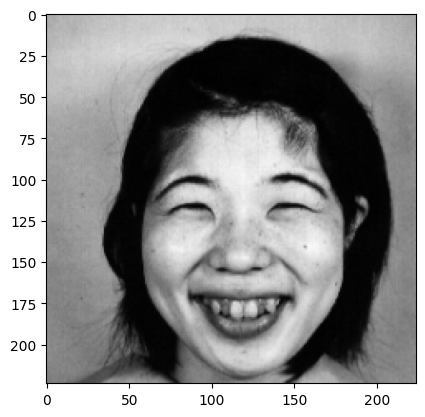

Predicted Label: happy
Label Probabilities:
angry: 2.76%
disgust: 27.89%
fear: 1.83%
happy: 56.07%
sad: 2.44%
surprise: 2.52%
neutral: 6.48%


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
# from 'EmoNeXt-master' import models
from ema_pytorch import EMA
import importlib  
models = importlib.import_module("EmoNeXt-master.models") #importing the models.py file from the EmoNeXt-master folder. Doesn't work normally due to the - in the directory name

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# 1. Load the saved model
# model_path = "TrainedModel/EmoNeXt-ModelSize_small_Epochs_20_BatchSize_32_LR_1e-05.pt"
model_path = "TrainedModel/NoAttentionLoss_EmoNeXt_ModelSize_small_Epochs_80_BatchSize_32_LR_1e-05.pt"

# Load the model architecture
# model = get_model(len(train_dataset.classes), "base", in_22k=False)  # Update model parameters accordingly
model = models.get_model(7, "small", in_22k=True) 

checkpoint = torch.load(model_path, map_location=device)

# Load the model weights
model.load_state_dict(checkpoint["model"], strict=False)

# 2. Put the model in evaluation mode
model.eval()

# 3. Define the same transformations that were used in training
test_transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.Resize(236),
        transforms.TenCrop(224),
        transforms.Lambda(
            lambda crops: torch.stack(
                [transforms.ToTensor()(crop) for crop in crops]
            )
        ),
        transforms.Lambda(
            lambda crops: torch.stack([crop.repeat(3, 1, 1) for crop in crops])
        ),
    ]
)

# 4. Load your test image (path to your image)
image_path = "TestImages/train_7_HAP.tiff"
image = Image.open(image_path)

# Apply the transformations to the image
image = test_transform(image)

# Adds the batch size dimension at 1
image = image.unsqueeze(0) 

# 5. Send the image to the same device as your model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image = image.to(device)

# Move model to the same device
model = model.to(device)

# Default values in train.py
ema_decay = 0.99
ema_update_every = 16

ema_model = EMA(model, beta=ema_decay, update_every=ema_update_every).to(device)

ema_model.load_state_dict(checkpoint["ema"], strict=False)
ema_model.eval()

# 6. Run inference on the image to get the final prediction and probabilities
with torch.no_grad():
    bs, ncrops, c, h, w = image.shape  # Expected shape: (1, 10, 3, 224, 224)
    inputs = image.view(-1, c, h, w)     # Merge batch and crops: (10, 3, 224, 224)
    
    # Forward pass through the ema_model; assuming the model returns a tuple (_, logits)
    _, logits = ema_model(inputs)
    
    # Reshape logits back to (batch_size, ncrops, num_classes) and average over crops
    outputs_avg = logits.view(bs, ncrops, -1).mean(1)
    
    predictions = torch.argmax(outputs_avg, dim=1)

    predicted_labels = predictions.tolist()
    predicted_class = predicted_labels[0]
    
    # Compute probabilities using softmax
    probabilities = F.softmax(outputs_avg, dim=1).cpu().numpy()[0]

# Define your class names (adjust as needed)
class_names = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# Print out the results
plt.imshow(image[0][0].cpu().permute(1, 2, 0).numpy())
plt.show()
print("Predicted Label:", class_names[predicted_class])
print("Label Probabilities:")
for cls, prob in zip(class_names, probabilities):
    print(f"{cls}: {prob*100:.2f}%")